In [2]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import warnings
import pandas as pd
import seaborn as sns

In [3]:
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [4]:
input_dir = '../Database/'
file_train = 'train.csv'
file_test = 'test.csv'
train = pd.read_csv(os.path.join(input_dir, file_train))
test = pd.read_csv(os.path.join(input_dir, file_test))

In [5]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출기간']))
train['대출기간'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출기간']))
test['대출기간'] = pd.DataFrame(encoder_data)

In [6]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['근로기간']))
train['근로기간'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['근로기간']))
test['근로기간'] = pd.DataFrame(encoder_data)

In [7]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['주택소유상태']))
train['주택소유상태'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['주택소유상태']))
test['주택소유상태'] = pd.DataFrame(encoder_data)

In [8]:
# train_dataset에는 없는 결혼 범주가 test_dataset에 1개 있음. 그것 제외.
test.drop(34486, inplace=True)

In [9]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출목적']))
train['대출목적'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출목적']))
test['대출목적'] = pd.DataFrame(encoder_data)

In [10]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출등급']))
train['대출등급'] = pd.DataFrame(encoder_data)

In [11]:
train.set_index(train['ID'], inplace=True)
train.pop('ID')

test.set_index(test['ID'], inplace=True)
test.pop('ID')

ID
TRAIN_00000    TRAIN_00000
TRAIN_00001    TRAIN_00001
TRAIN_00002    TRAIN_00002
TRAIN_00003    TRAIN_00003
TRAIN_00004    TRAIN_00004
                  ...     
TRAIN_96289    TRAIN_96289
TRAIN_96290    TRAIN_96290
TRAIN_96291    TRAIN_96291
TRAIN_96292    TRAIN_96292
TRAIN_96293    TRAIN_96293
Name: ID, Length: 96294, dtype: object

ID
TEST_00000    TEST_00000
TEST_00001    TEST_00001
TEST_00002    TEST_00002
TEST_00003    TEST_00003
TEST_00004    TEST_00004
                 ...    
TEST_64192    TEST_64192
TEST_64193    TEST_64193
TEST_64194    TEST_64194
TEST_64195    TEST_64195
TEST_64196    TEST_64196
Name: ID, Length: 64196, dtype: object

In [12]:
from sklearn.decomposition import PCA

def do_pca(X_pca):
    columns_pca = [f'PCA_{i}' for i in range(1, X_pca.shape[1] + 1)]
    X_pca_df = pd.DataFrame(X_pca, columns=columns_pca)
    return X_pca_df

In [13]:
scaler = StandardScaler()
pca = PCA(n_components=0.99)

gt = pd.DataFrame(train['대출등급'], columns=['대출등급'])
to_normalize_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
X = pd.DataFrame(train[to_normalize_list], columns=to_normalize_list, index=train.index)
Y = pd.DataFrame(test[to_normalize_list], columns=to_normalize_list, index=test.index)

data_scaled = scaler.fit_transform(X)
# X_pca = pca.fit_transform(data_scaled)
# data_scaled = do_pca(X_pca)
# data_scaled.index = train.index

data_scaled=pd.DataFrame(data_scaled, columns=to_normalize_list, index=train.index)

train.drop(columns=to_normalize_list, inplace=True)
train.drop(columns='대출등급', inplace=True)
train = pd.concat([gt, data_scaled, train], axis=1)

data_scaled = scaler.transform(Y)
# X_pca = pca.transform(data_scaled)
# data_scaled = do_pca(X_pca)
# data_scaled.index = test.index

data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=test.index)

test.drop(columns=to_normalize_list, inplace=True)
test = pd.concat([data_scaled, test], axis=1)
# print(pca.explained_variance_ratio_)

In [14]:
test.dropna(inplace=True)
plt.rc('font', family='GULIM')

In [15]:
category_list = ['대출기간', '근로기간', '주택소유상태', '대출목적']

for i in range(len(category_list)):
    contingency_table = pd.crosstab(train['대출등급'], train[category_list[i]])
    chi, p, dof, expected = chi2_contingency(contingency_table)
    print(f'{category_list[i]} chi: {chi}, p_value: {p}')

대출기간 chi: 19134.184195744863, p_value: 0.0
근로기간 chi: 187.56633181905977, p_value: 7.714129711631081e-09
주택소유상태 chi: 663.4327372511038, p_value: 3.225488826409481e-129
대출목적 chi: 5744.213056799291, p_value: 0.0


In [16]:
X = train[to_normalize_list]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

       Variable       VIF
0          대출금액  1.816086
1          연간소득  1.103885
2   부채_대비_소득_비율  1.007299
3          총계좌수  1.075159
4  최근_2년간_연체_횟수  1.034358
5         총상환원금  1.247752
6         총상환이자  1.735677
7         총연체금액  1.004337
8         연체계좌수  1.018452


In [17]:
corr_A_B = pearsonr(train['대출등급'], train['총상환이자'])[0]
corr_A_C = pearsonr(train['대출등급'], train['총상환원금'])[0]
corr_B_C = pearsonr(train['총상환이자'], train['총상환원금'])[0]
partial_corr= (corr_A_C - (corr_B_C * corr_A_B)) / ((1 - corr_B_C**2)*(1 - corr_A_B**2))**0.5

print(partial_corr)

-0.3488384082005012


<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

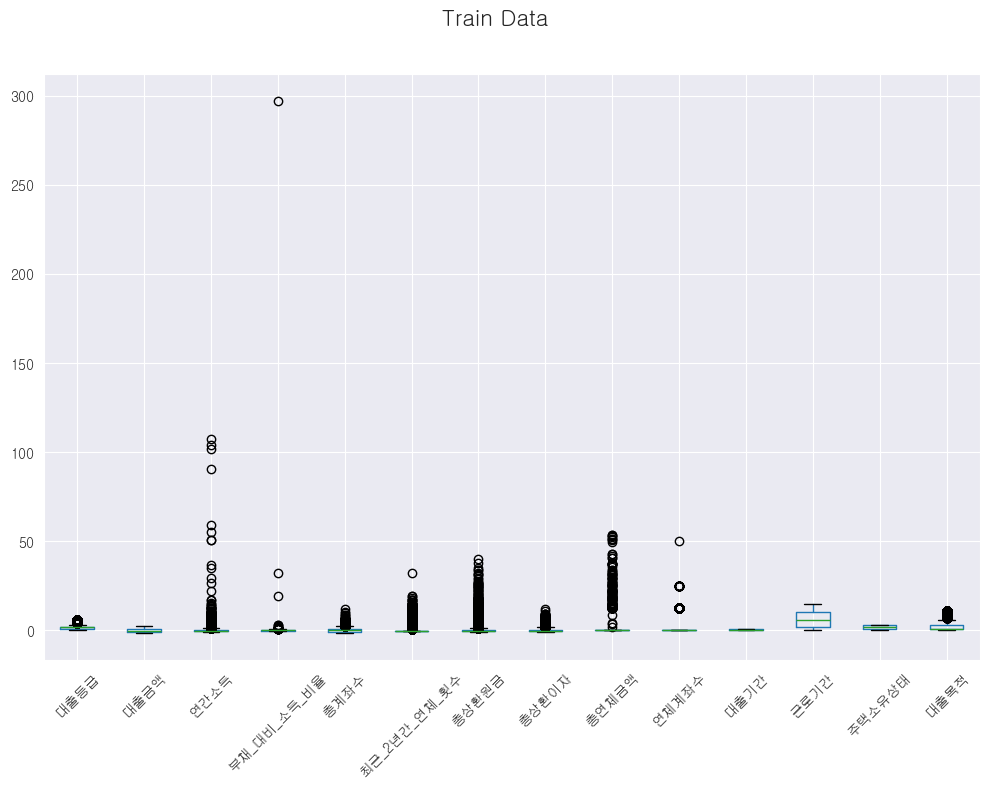

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [19]:
col = '연간소득'

Q1 = train[col].quantile(0.995)
Q3 = train[col].quantile(0.005)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)
train.drop(outliers_index, inplace=True)

964

96294

In [20]:
col = '부채_대비_소득_비율'

Q1 = train[col].quantile(0.995)
Q3 = train[col].quantile(0.005)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)
train.drop(outliers_index, inplace=True)

950

95330

In [21]:
col = '최근_2년간_연체_횟수'

Q1 = train[col].quantile(0.995)
Q3 = train[col].quantile(0.005)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)
train.drop(outliers_index, inplace=True)

454

94380

In [22]:
col = '총상환원금'

Q1 = train[col].quantile(0.995)
Q3 = train[col].quantile(0.005)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)
train.drop(outliers_index, inplace=True)

448

93926

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

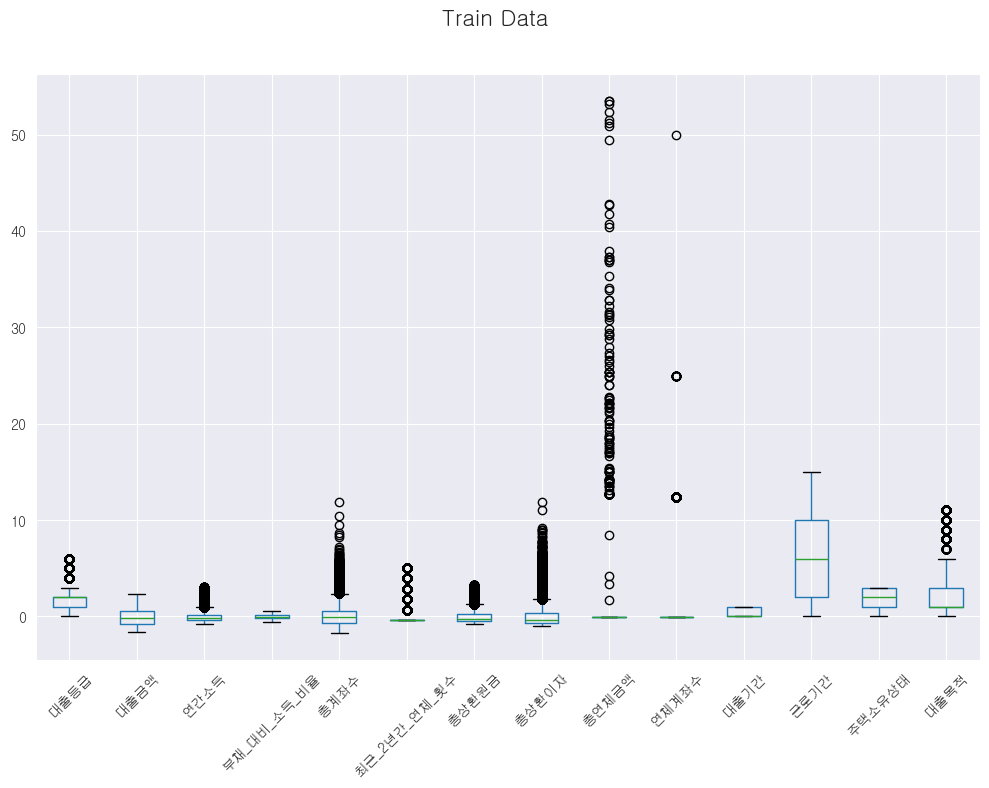

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Heatmap')

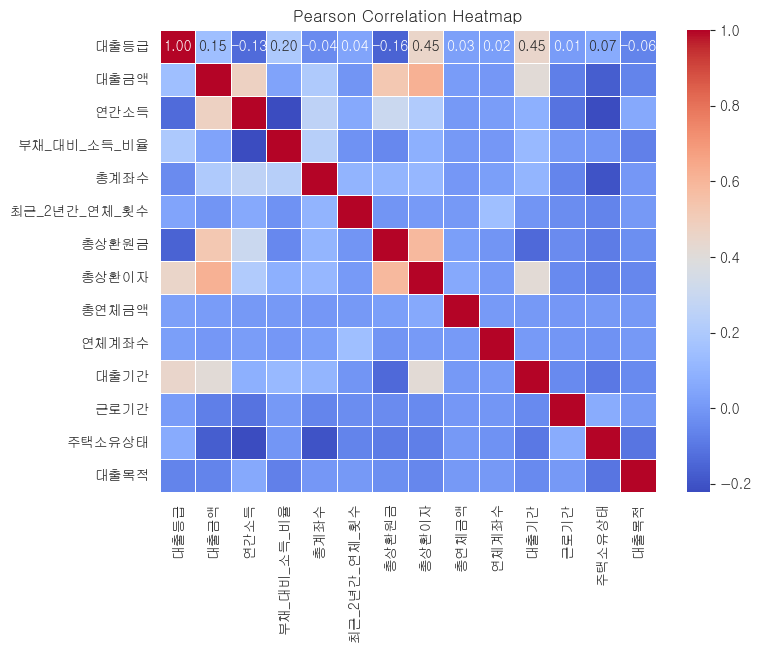

In [24]:
correlation_matrix = train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Spearman Correlation Heatmap')

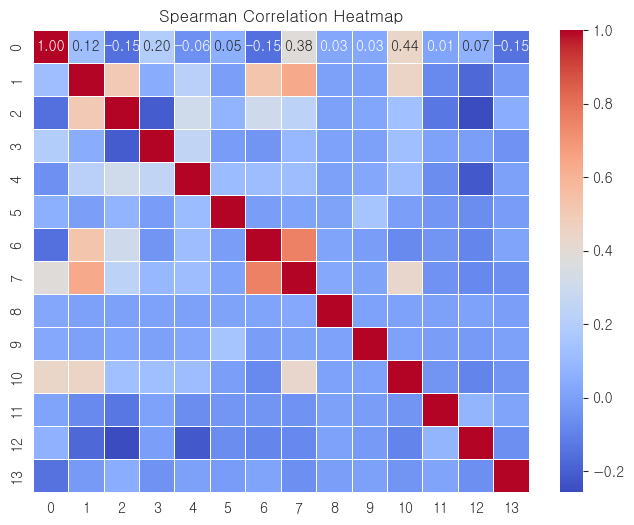

In [25]:
correlation_matrix, _ = spearmanr(train)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

In [26]:
train.drop(columns=['총계좌수', '총연체금액', '연체계좌수'], inplace=True)
test.drop(columns=['총계좌수', '총연체금액', '연체계좌수'], inplace=True)
# train.drop(columns='PCA_8', inplace=True)
# test.drop(columns='PCA_8', inplace=True)
# train.to_csv('../Database/train_modified4.csv')
# test.to_csv('../Database/test_modified4.csv')

In [28]:
train

,대출등급,대출금액,연간소득,부채_대비_소득_비율,최근_2년간_연체_횟수,총상환원금,총상환이자,대출기간,근로기간,주택소유상태,대출목적
ID,,,,,,,,,,,
TRAIN_00000,2,-0.563848,-0.220218,-0.014287,-0.376102,-0.800303,-0.972784,0,9,3,1
TRAIN_00001,1,-0.377964,0.370332,0.087890,-0.376102,-0.436814,-0.441082,1,2,1,10
TRAIN_00002,0,-0.610319,0.020823,-0.321114,-0.376102,0.103276,-0.627621,0,8,1,1
TRAIN_00003,2,-0.377964,0.382384,-0.127783,-0.376102,-0.483274,-0.624977,0,11,1,1
TRAIN_00004,1,-0.029431,-0.222870,0.179044,-0.376102,-0.577932,-0.634409,1,15,3,8
...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_96289,2,-0.377964,1.165767,-0.299368,-0.376102,0.147972,0.145249,0,2,1,3
TRAIN_96290,4,1.016166,0.382384,-0.423588,-0.376102,-0.232331,0.969667,1,2,1,10
TRAIN_96291,0,-0.377964,-0.099698,-0.242471,-0.376102,0.648632,-0.424781,0,0,1,3
